In [1]:
from gpt2_functions import *

## Download the data on which we will train the model and save it to disk

In [2]:
with open("../data/the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

print("Total number of characters in the text:", len(raw_text))

Total number of characters in the text: 20479


## Configure our special GPT2 model

In [3]:
# specify configuration of small GPT-2 model
GPT_CONFIG_124M = {
    "vocab_size": 50257, 
    "context_length": 256, #1024,
    "emb_dim": 768,
    "n_heads": 12, #number of attention heads
    "n_layers": 12, #number of transformer blocks
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [4]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)


In [5]:
# Compute the total params that are to be trained
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,419,712


In [6]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [8]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())                   
    )
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
) 

Number of trainable parameters considering weight tying: 123,822,336


Weight tying is essentially when the GPT-2 architecture reuses the weights from the token embedding layer in its output layer.

In [9]:
total_size_bytes = total_params*4
total_size_mb = total_size_bytes/(1024*1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 619.58 MB


## Generating text from an untrained GPT2 model

In [10]:
start_context = "Every effort moves you "
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model, idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size = GPT_CONFIG_124M["context_length"])

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you  Stores behavedaiden Refer launch Compos Burn wonderiterranean alliance


In [11]:
# We've already read in the verdict as raw_text
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))
print("characters:", total_characters)
print("tokens:", total_tokens)

characters: 20479
tokens: 5145


# Split raw_text into training and validation datasets

In [12]:
train_ratio = 0.9
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]
print("Training data size:",len(train_data))
print("Validation data size:", len(val_data))      

Training data size: 18431
Validation data size: 2048


In [13]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"], #so totally non-overlapping
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"], #so totally non-overlapping
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [14]:
print("Train loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


# Report initial training and validation losses on untrained model

In [17]:
device = torch.device("mps") #torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

In [15]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)    

Training loss: 10.986602677239311
Validation loss: 10.981025695800781


# Main: Training the model (10 epochs, AdamW, train_model_simple)

In [18]:
## Initialize the AdamW optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

num_epochs = 10

In [19]:
## Main training loop
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss  9.690, Val loss  9.963
Ep 1 (Step 000005): Train loss  8.049, Val loss  8.306
Every effort moves you, the the the the the the the the the the the the the.                                   
Ep 2 (Step 000010): Train loss  6.617, Val loss  7.034
Ep 2 (Step 000015): Train loss  6.110, Val loss  6.578
Every effort moves you, the, the, the, the, the, the, the the, the, the, the, the, the, the, the the, the, the, the, the, the, the, the, the, the, the
Ep 3 (Step 000020): Train loss  5.737, Val loss  6.432
Ep 3 (Step 000025): Train loss  5.600, Val loss  6.509
Every effort moves you.                                                 
Ep 4 (Step 000030): Train loss  5.644, Val loss  6.567
Ep 4 (Step 000035): Train loss  5.069, Val loss  6.561
Every effort moves you""""""""" I had a a of the of the of the"-- his the" I had the of the of the of the of the of the of the of the of the of the of the of the of
Ep 5 (Step 000040): Train loss  4.579, Val loss  6.382
Ever

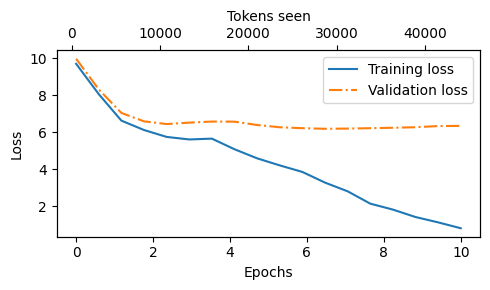

In [20]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)  

Seems like the model has memorized the data because training data loss dropped while validation loss didn't drop nearly as much. This makes sense because our training set is very tiny.

In [23]:
# put the model in eval mode to turn off random components like dropout
model.eval()
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [27]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=20,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the fact with his last word.





# Temperature Scaling to introduce probabilistic sampling

In [28]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"
G my surpriseed chair, his pictures-- toldas such purely


# Loading and saving model weights in Pytorch

In [29]:
# Save the current trained model
torch.save(model.state_dict(), "model.pth")

In [30]:
# Load the model to a new GPT instance
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [31]:
# Save the model and the optimizer state_dict contents
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth")